In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Utilizada para fazer calculos de atrition e gráficos
import seaborn as sns           # Utilizada para fazer calculos de atrition e gráficos
from sklearn.ensemble import RandomForestClassifier # Treinar um modelo rápido (como árvore de decisão ou random forest) para medir a importância das features:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures # PolynomialFeatures (exemplo: interação quadrática entre variáveis de satisfação)
from sklearn.impute import SimpleImputer # Estratégia simples: preenchendo com média (para numéricas) e modo (para categóricas) (Possívelmente não usado)
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV # 3.3 Otimização de hiperparâmetros
import warnings
#3.0 Modelagem
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer                             # 3.1 SimpleImputer para preencher os valores ausentes antes de treinar os modelos:
from imblearn.over_sampling import SMOTE                             # 3.2 Tratamento adequado do desbalanceamento
from sklearn.model_selection import GridSearchCV                     # 3.3 Otimização de hiperparâmetros
from sklearn.model_selection import cross_val_score, StratifiedKFold # 3.4 Usar validação estratificada (mantém proporções)
from sklearn.ensemble import VotingClassifier                        # 3.5 Ensemble Methods -- Combinar modelos para melhorar desempenho
# 4.0 Avaliação e interpretação
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score # 4.1  Métricas apropriadas para desbalanceamento

warnings.filterwarnings('ignore')

#1 -ANALISE EXPLORATÓRIA
# Configurações de visualização

# Aplica o estilo “darkgrid” do seaborn na versão compatível com matplotlib.
# Esse estilo:
# Usa fundo claro com grades cinza discretas.
# Deixa os gráficos mais bonitos e legíveis.
# É útil para relatórios e apresentações.
plt.style.use('seaborn-v0_8-darkgrid')

# Define a paleta de cores que o Seaborn usará para gráficos com várias categorias (ex: barras, linhas etc.).
# "husl" é uma paleta baseada em matiz, saturação e luminosidade. Ela gera cores vibrantes e distintas, ideais para comparar várias classes com clareza.
sns.set_palette("husl")

# 1. CARREGAMENTO DOS DADOS
# Dataset: IBM HR Analytics Employee Attrition & Performance
# Você pode baixar de: https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset

# Para este exemplo, vou criar um dataset sintético similar
np.random.seed(42)

# Criando dataset sintético para demonstração
n_samples = 1_000

data = {
    'Age': np.random.randint(18, 65, n_samples),
    'Attrition': np.random.choice(['Yes', 'No'], n_samples, p=[0.16, 0.84]),
    'BusinessTravel': np.random.choice(['Travel_Rarely', 'Travel_Frequently', 'Non-Travel'], n_samples),
    'DailyRate': np.random.randint(100, 1500, n_samples),
    'Department': np.random.choice(['Sales', 'Research & Development', 'Human Resources'], n_samples),
    'DistanceFromHome': np.random.randint(1, 30, n_samples),
    'Education': np.random.randint(1, 5, n_samples),
    'EducationField': np.random.choice(['Life Sciences', 'Other', 'Medical', 'Marketing', 'Technical Degree', 'Human Resources'], n_samples),
    'EmployeeCount': np.ones(n_samples, dtype=int),
    'EmployeeNumber': np.arange(1, n_samples + 1),
    'EnvironmentSatisfaction': np.random.randint(1, 5, n_samples),
    'Gender': np.random.choice(['Female', 'Male'], n_samples),
    'HourlyRate': np.random.randint(30, 100, n_samples),
    'JobInvolvement': np.random.randint(1, 5, n_samples),
    'JobLevel': np.random.randint(1, 6, n_samples),
    'JobRole': np.random.choice(['Sales Executive', 'Research Scientist', 'Laboratory Technician',
                                'Manufacturing Director', 'Healthcare Representative', 'Manager',
                                'Sales Representative', 'Research Director', 'Human Resources'], n_samples),
    'JobSatisfaction': np.random.randint(1, 5, n_samples),
    'MaritalStatus': np.random.choice(['Single', 'Married', 'Divorced'], n_samples),
    'MonthlyIncome': np.random.randint(1000, 20000, n_samples),
    'MonthlyRate': np.random.randint(2000, 27000, n_samples),
    'NumCompaniesWorked': np.random.randint(0, 10, n_samples),
    'Over18': ['Y'] * n_samples,
    'OverTime': np.random.choice(['Yes', 'No'], n_samples, p=[0.28, 0.72]),
    'PercentSalaryHike': np.random.randint(11, 26, n_samples),
    'PerformanceRating': np.random.choice([3, 4], n_samples, p=[0.84, 0.16]),
    'RelationshipSatisfaction': np.random.randint(1, 5, n_samples),
    'StandardHours': [80] * n_samples,
    'StockOptionLevel': np.random.randint(0, 4, n_samples),
    'TotalWorkingYears': np.random.randint(0, 40, n_samples),
    'TrainingTimesLastYear': np.random.randint(0, 7, n_samples),
    'WorkLifeBalance': np.random.randint(1, 5, n_samples),
    'YearsAtCompany': np.random.randint(0, 40, n_samples),
    'YearsInCurrentRole': np.random.randint(0, 19, n_samples),
    'YearsSinceLastPromotion': np.random.randint(0, 16, n_samples),
    'YearsWithCurrManager': np.random.randint(0, 18, n_samples),
    # Novas variáveis
    'RemoteWorkFrequency': np.random.choice(['Never', 'Sometimes', 'Often', 'Always'], n_samples, p=[0.2, 0.4, 0.3, 0.1]),
    'TechStackCompatibility': np.random.randint(1, 6, n_samples),  # 1 (baixa) a 5 (alta)
    'InternalMobilityOpportunities': np.random.choice(['None', 'Few', 'Moderate', 'High'], n_samples, p=[0.3, 0.3, 0.3, 0.1]),
    'TeamCohesionScore': np.random.randint(1, 6, n_samples),  # 1 (fraca) a 5 (forte)
    'ManagerFeedbackFrequency': np.random.poisson(2, n_samples),  # vezes por mês (média 2)
    'RecentOrganizationalChanges': np.random.choice(['Yes', 'No'], n_samples, p=[0.25, 0.75]),
    'JobMarketConfidence': np.random.randint(1, 6, n_samples)  # 1 (baixa confiança) a 5 (muito alta)

}

# RemoteWorkFrequency
# 📊 Negócio: Flexibilidade no trabalho remoto é um fator-chave de retenção no setor de tecnologia.
# 🧠 Técnico: Pode indicar correlação negativa com o attrition (quanto mais remoto, menor turnover).

# TechStackCompatibility
# 📊 Negócio: Funcionários que trabalham com tecnologias que dominam tendem a estar mais satisfeitos.
# 🧠 Técnico: Pode influenciar positivamente na produtividade e diminuir o desejo de mudar de empresa.

# InternalMobilityOpportunities
# 📊 Negócio: Empresas que oferecem oportunidades internas reduzem a evasão por estagnação.
# 🧠 Técnico: Pode impactar diretamente no tempo de permanência na empresa (YearsAtCompany).

# TeamCohesionScore
# 📊 Negócio: Equipes coesas aumentam a motivação e reduzem conflitos e desligamentos.
# 🧠 Técnico: Pode ter alta interação com JobSatisfaction e RelationshipSatisfaction.

# ManagerFeedbackFrequency
# 📊 Negócio: Funcionários que recebem feedback constante tendem a se sentir mais valorizados e orientados.
# 🧠 Técnico: Pode estar correlacionado positivamente com PerformanceRating e negativamente com Attrition.

# RecentOrganizationalChanges -- Muito importante
# 📊 Negócio: Mudanças organizacionais (fusões, cortes, reestruturações) aumentam insegurança e rotatividade.
# 🧠 Técnico: Pode ser tratada como feature de risco (similar a uma "flag" de eventos).

# JobMarketConfidence
# 📊 Negócio: Pessoas que acreditam poder encontrar emprego facilmente estão mais propensas a sair.
# 🧠 Técnico: Útil para representar contexto externo à empresa, agregando dimensão econômica ao modelo.

df = pd.DataFrame(data)
df.head(100).to_excel("meu_arquivo.xlsx", index=False)

# Ajustando algumas relações lógicas
df.loc[df['YearsAtCompany'] < df['YearsInCurrentRole'], 'YearsInCurrentRole'] = df['YearsAtCompany']
df.loc[df['YearsAtCompany'] < df['YearsSinceLastPromotion'], 'YearsSinceLastPromotion'] = df['YearsAtCompany']
df.loc[df['TotalWorkingYears'] < df['YearsAtCompany'], 'TotalWorkingYears'] = df['YearsAtCompany']

# Analise estatistica completa do código
df.describe()
df.info()
df['Attrition'].value_counts(normalize=True)

df.hist(bins=30, figsize=(15, 10))  # Histograma geral
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Histogramas
df[numeric_cols].hist(bins=30, figsize=(15, 10))
plt.suptitle('Distribuição das Variáveis Numéricas')
plt.show()

# Boxplots
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot - {col}')
    plt.show()

# Assimetria e Curtose
skewness = df[numeric_cols].skew()
kurtosis = df[numeric_cols].kurtosis()
print("\nAssimetria:\n", skewness)
print("\nCurtose:\n", kurtosis)

# 🔍 Correlação entre variáveis numéricas
plt.figure(figsize=(16, 12))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title('Mapa de Calor - Correlação entre Variáveis Numéricas')
plt.show()

# 🎯 Relação entre renda mensal e attrition
plt.figure(figsize=(8, 6))
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df)
plt.title('Distribuição da Renda Mensal por Attrition')
plt.ylabel('Monthly Income')
plt.xlabel('Attrition')
plt.show()

# 💡 Insights de negócio: tempo médio de empresa por grupo de attrition
insights = df.groupby('Attrition')['YearsAtCompany'].agg(['mean', 'median', 'std']).reset_index()
print("\nTempo de empresa por grupo de Attrition:\n")
print(insights)

#  gráfico de barras comparando tempo médio de empresa
plt.figure(figsize=(6, 4))
sns.barplot(x='Attrition', y='mean', data=insights)
plt.title('Tempo Médio de Empresa por Grupo de Attrition')
plt.ylabel('Média de Anos na Empresa')
plt.xlabel('Attrition')
plt.show()

# Variáveis com outlier
iqr = df[numeric_cols].quantile(0.75) - df[numeric_cols].quantile(0.25)
outliers = ((df[numeric_cols] < (df[numeric_cols].quantile(0.25) - 1.5 * iqr)) |
            (df[numeric_cols] > (df[numeric_cols].quantile(0.75) + 1.5 * iqr)))
outlier_counts = outliers.sum().sort_values(ascending=False)
print("\nQuantidade de outliers por coluna:\n", outlier_counts)

# Verificando valores ausentes
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
print("\nValores ausentes por coluna (%):\n", missing_percent[missing_percent > 0])

# Separar colunas numéricas e categóricas
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

# Preencher numéricas com média
num_imputer = SimpleImputer(strategy='mean')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Preencher categóricas com modo
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

print("\n✔️ Dados faltantes tratados com imputação.")


ModuleNotFoundError: No module named 'pandas'


=== FEATURE ENGINEERING ===
Novas features criadas:
['ViagensATrabalho', 'Insatisfacao', 'EstressePorDeslocamento', 'IHoraExtra', 'IdadeComecouTrabalhar', 'FaixaEtaria', 'SalarioCargo', 'ParticipaProgramaAcoes', 'SatisfacaoEnvolvimento', 'MaiorDistanciaDoTrabalho', 'SatisfacaoMediaPessoal', 'DiferencaEnvolvimentoSatisfacao', 'DesequilibrioVidaTrabalho', 'IdadeTempoNaEmpresa']


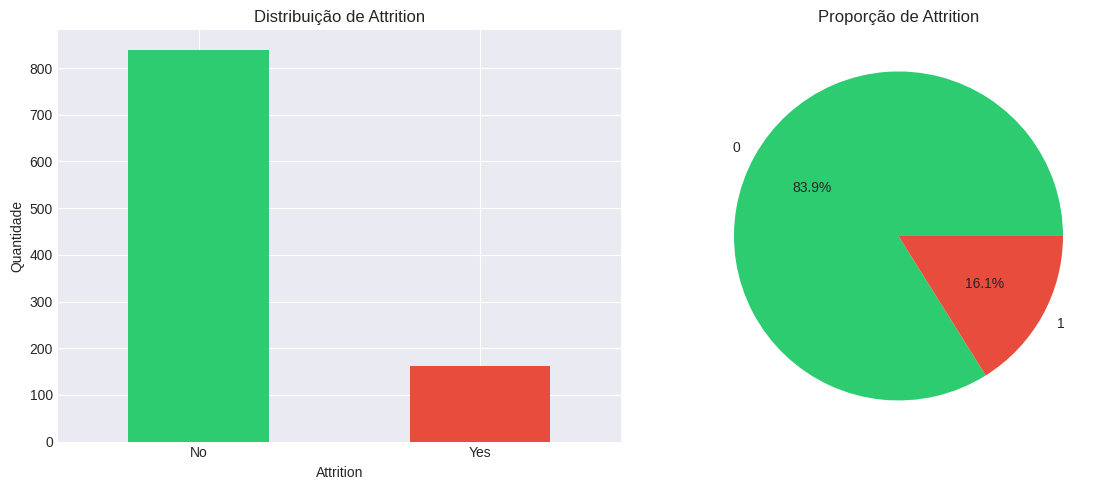


=== ANÁLISE DE VALORES AUSENTES ===
IdadeComecouTrabalhar    501
dtype: int64

=== VARIÁVEIS NUMÉRICAS (45) ===
['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'TechStackCompatibility', 'TeamCohesionScore', 'ManagerFeedbackFrequency', 'JobMarketConfidence', 'SatisfacaoMedia', 'SatisfacaoMediaPessoal', 'SatisfacaoEnvolvimento', 'MaiorDistanciaDoTrabalho', 'SalarioCargo', 'ParticipaProgramaAcoes', 'ViagensATrabalho', 'IHoraExtra', 'EstressePorDeslocamento', 'Insatisfacao', 'IdadeComecouTrabalhar', 'IdadeTempoNaEmpresa', 'Desequilibrio

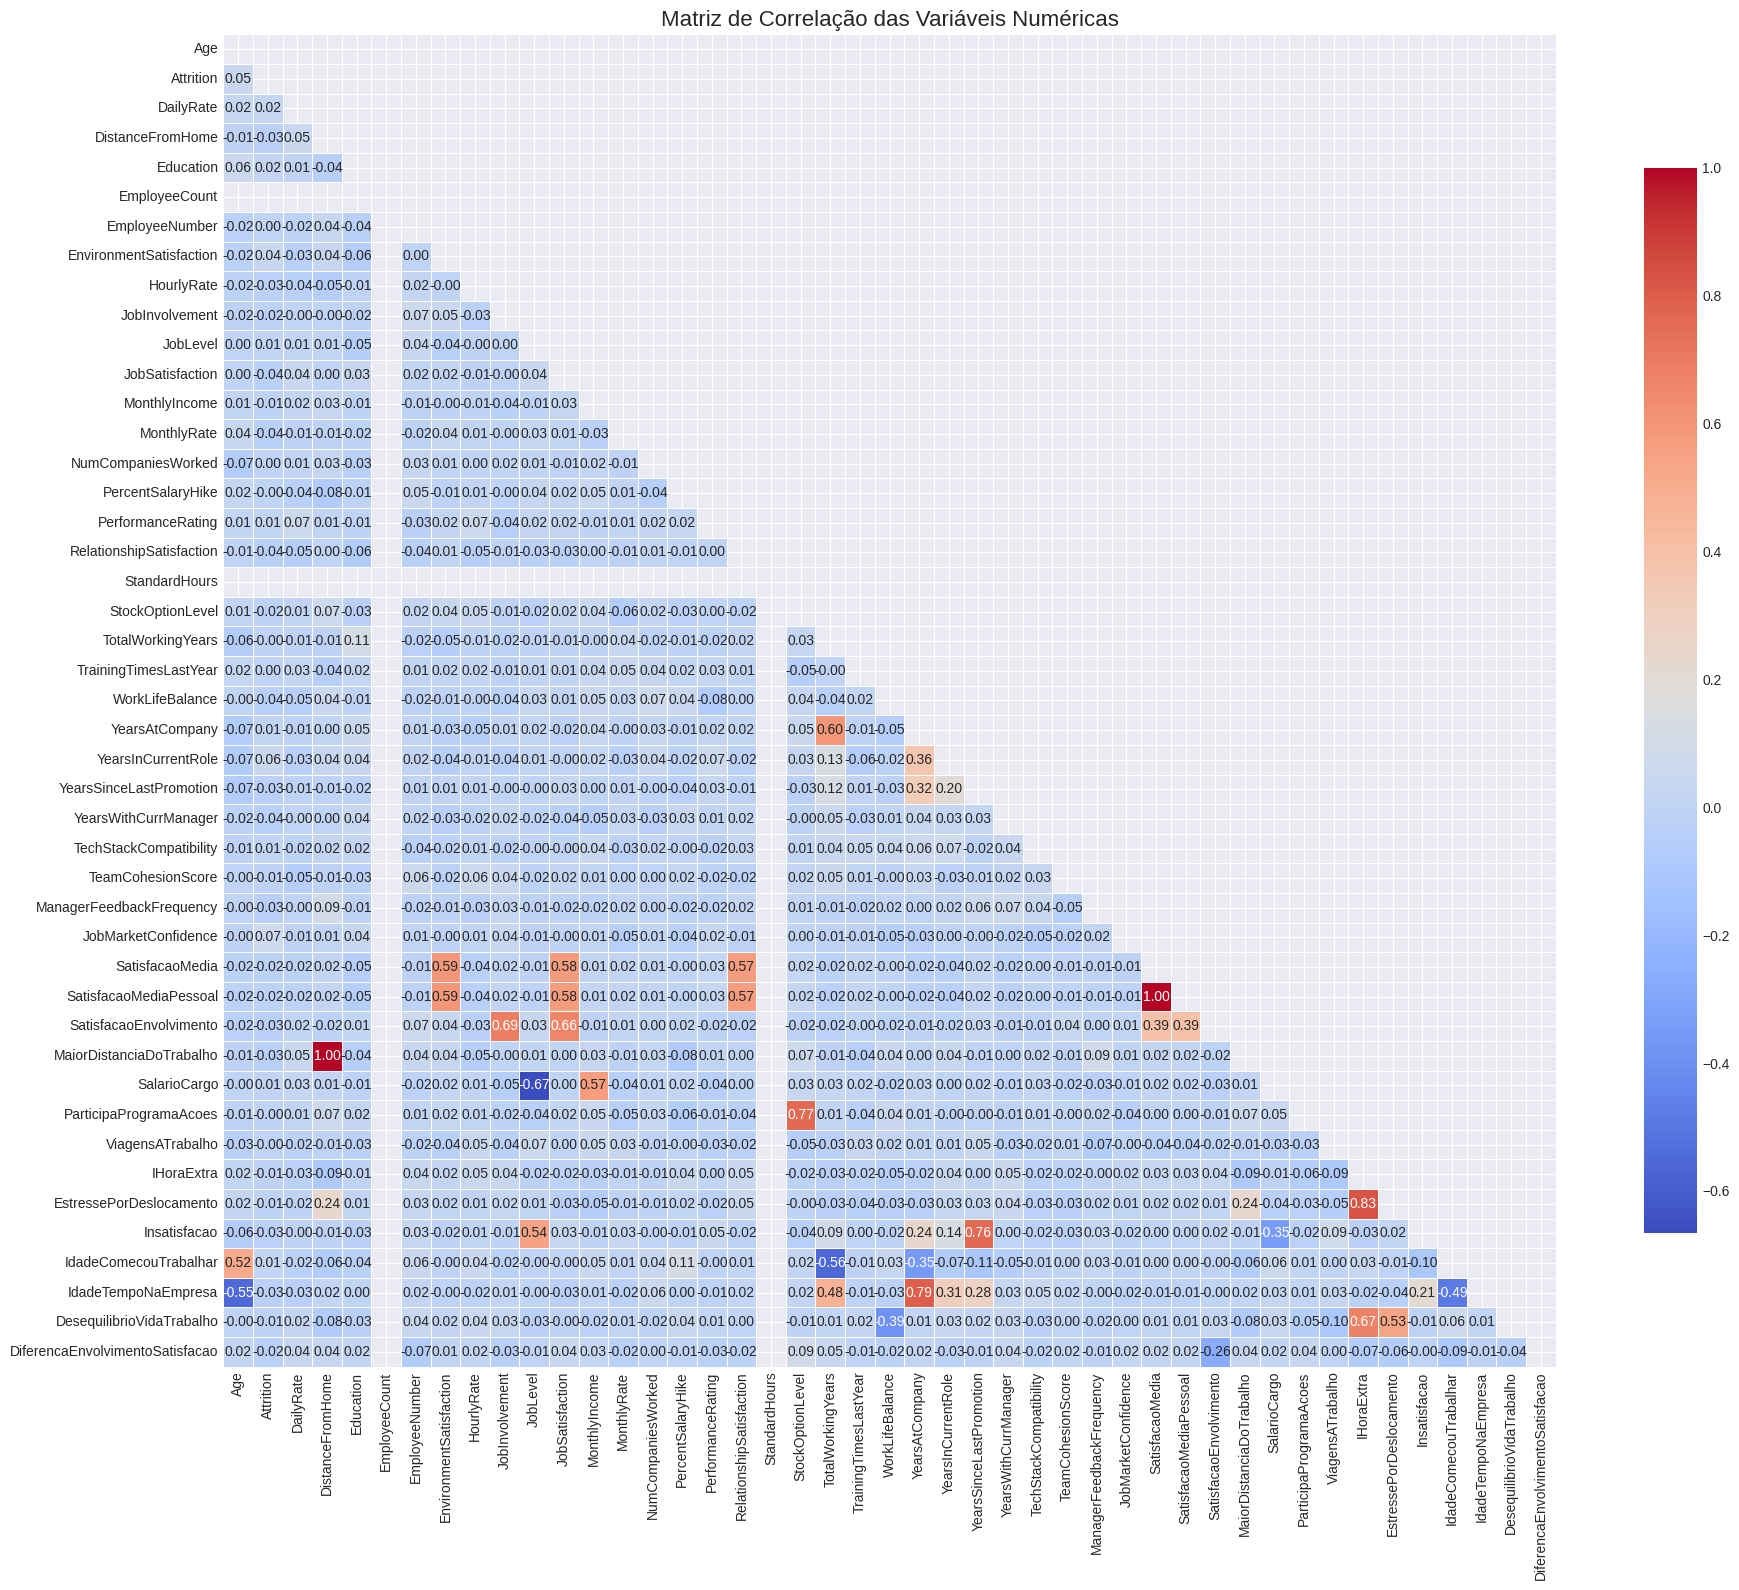

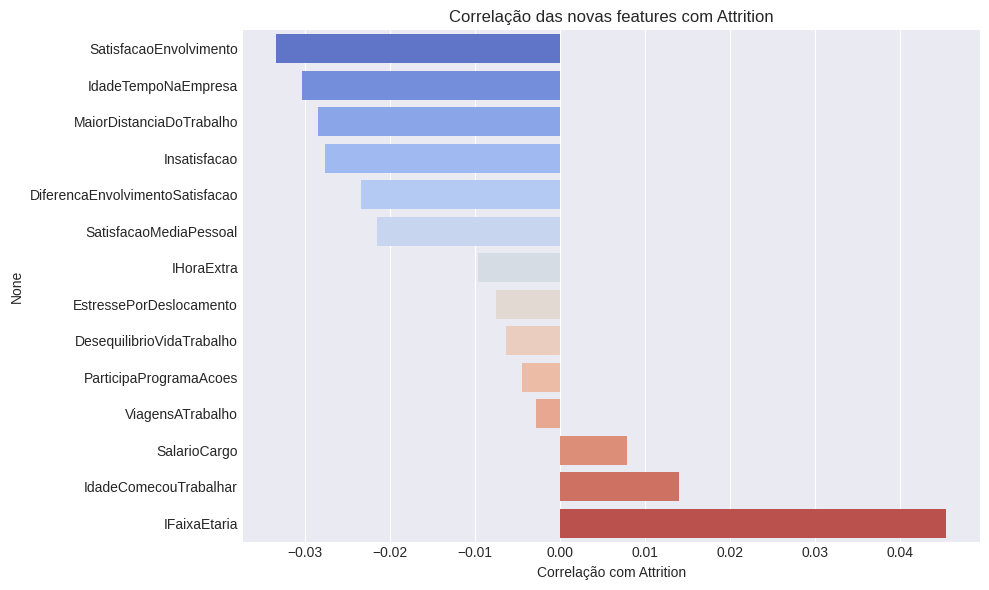

MODELO RÁPIDO


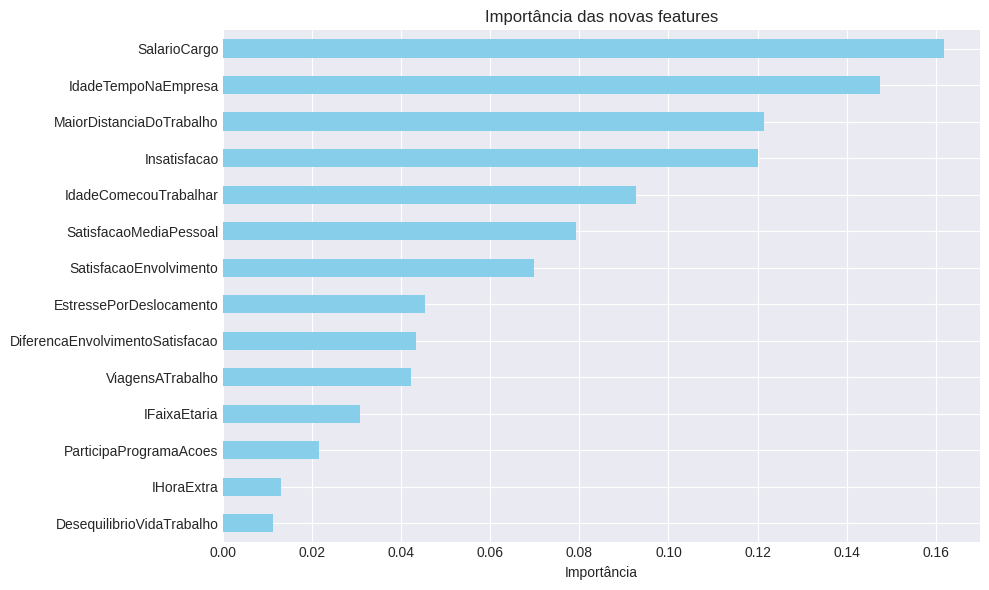

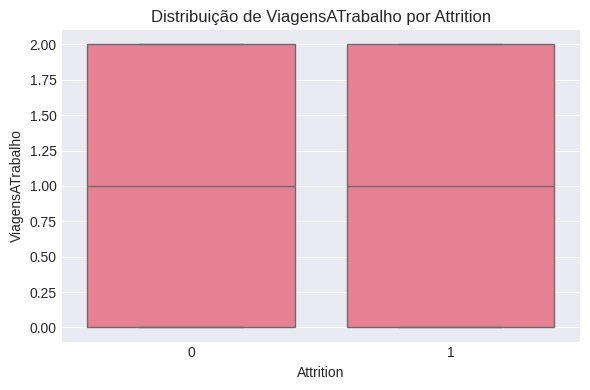

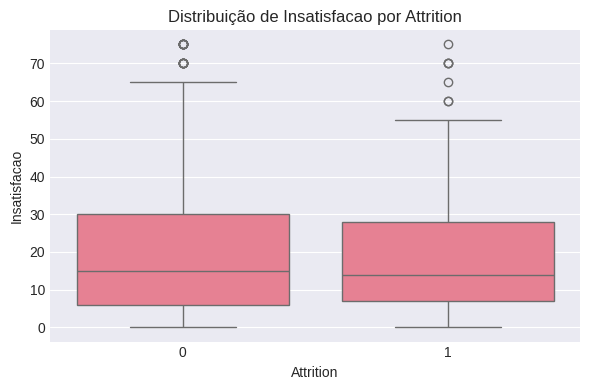

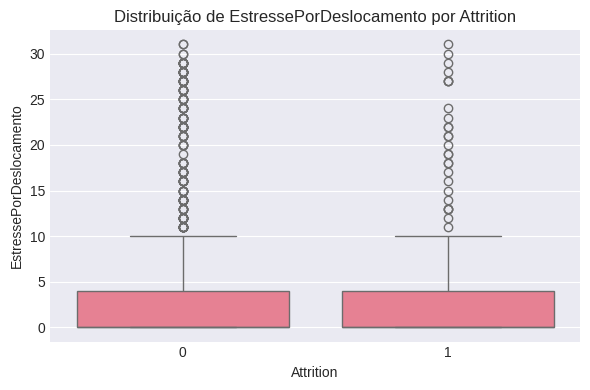

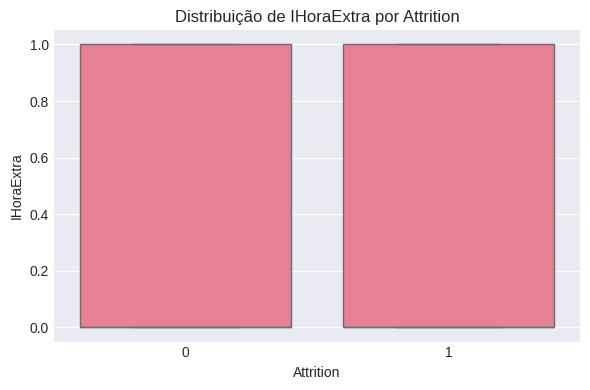

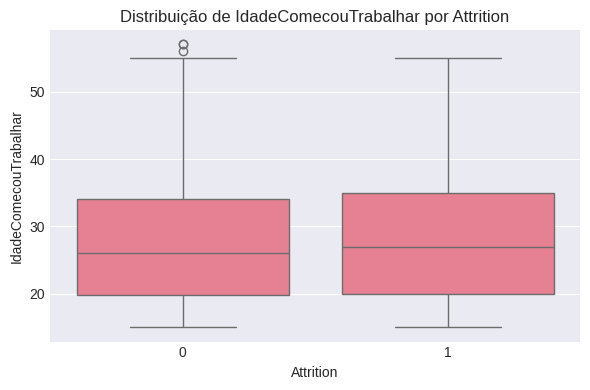

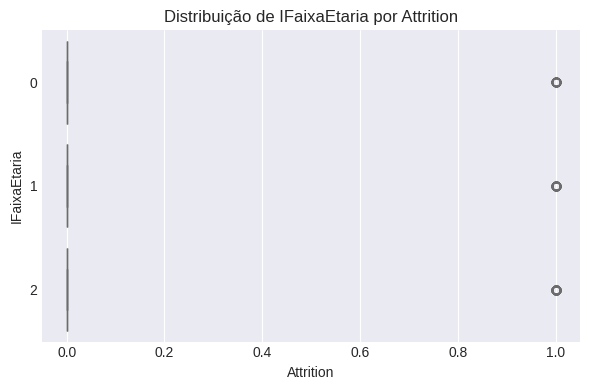

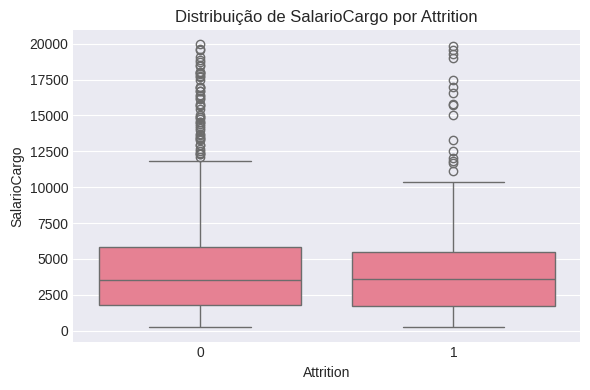

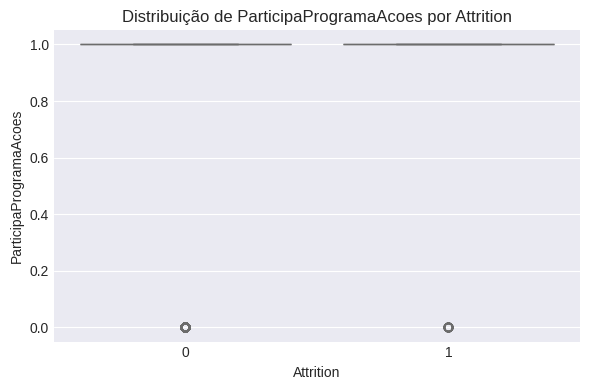

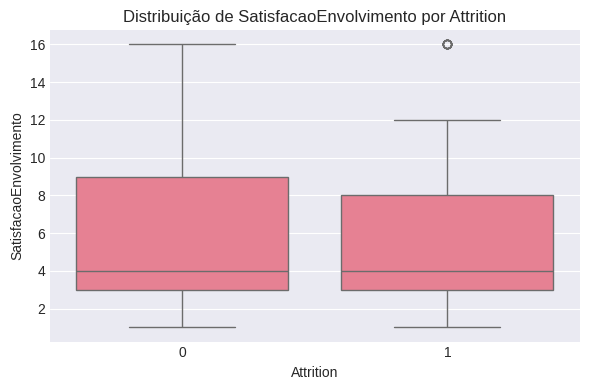

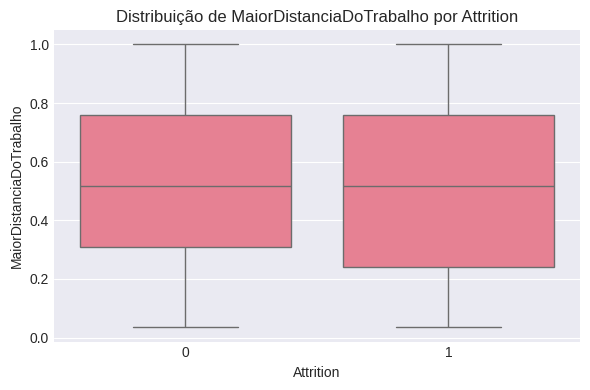

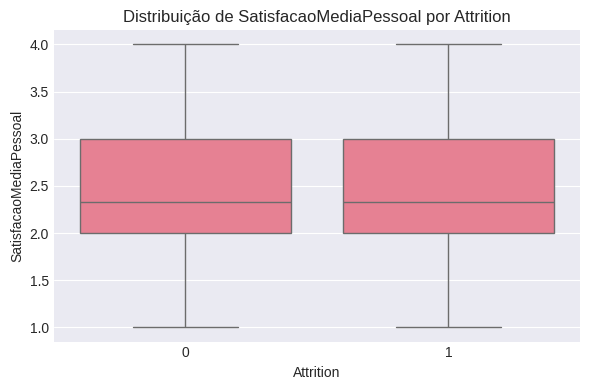

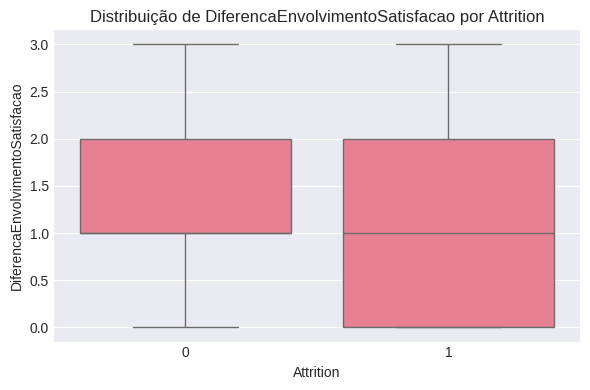

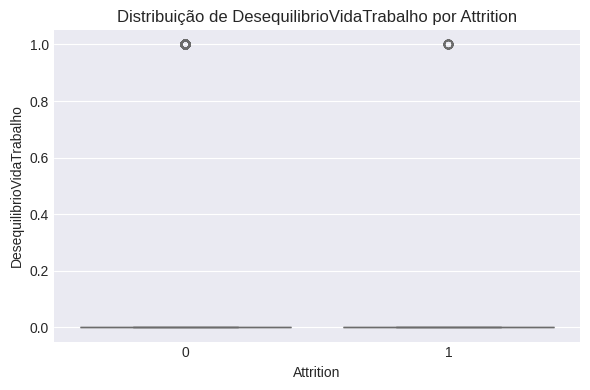

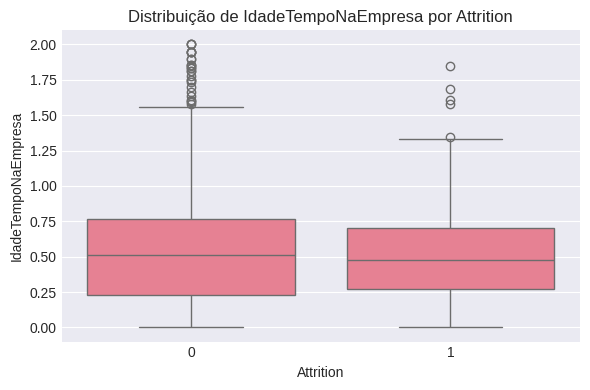

      Age  Attrition  DailyRate              Department  DistanceFromHome  \
0    56.0          0      459.0  Research & Development              15.0   
1    46.0          0     1198.0         Human Resources              17.0   
2    32.0          0      659.0                   Sales              17.0   
3    60.0          0      771.0  Research & Development              22.0   
4    25.0          0     1241.0                   Sales              26.0   
..    ...        ...        ...                     ...               ...   
995  22.0          0     1492.0  Research & Development              15.0   
996  40.0          0      895.0  Research & Development               3.0   
997  27.0          0      964.0         Human Resources              19.0   
998  61.0          0      648.0                   Sales              10.0   
999  19.0          1      748.0  Research & Development              28.0   

     Education    EducationField  EmployeeCount  EmployeeNumber  \
0       

In [43]:
# 2. FEATURE ENGINEERING


print("\n=== FEATURE ENGINEERING ===")

# Criando cópia do dataframe
df_feature = df.copy()

# ----------------------------------------------------------------------------------------------------------------------------------#
# ------------------------------------------------ Etapa 2.1 e Etapa 2.2 -----------------------------------------------------------#
# ----------------------------------------------------------------------------------------------------------------------------------#
##### 2.1 e 2.2 ##### Criando novas features / Escrevendo a nível técnico e de negócio as suas funções


# Satisfação Média Geral
# Justificativa: consolida percepções do ambiente em uma única métrica.
df_feature['SatisfacaoMedia'] = (df_feature['JobSatisfaction'] + df_feature['EnvironmentSatisfaction'] + df_feature['RelationshipSatisfaction']) / 3

# Satisfação Média Pessoal
# Justificativa: consolida percepções do ambiente em uma única métrica.
# Técnico: Agrega variáveis de satisfação em uma única média contínua.
df_feature['SatisfacaoMediaPessoal'] = df_feature[['JobSatisfaction', 'EnvironmentSatisfaction', 'RelationshipSatisfaction']].mean(axis=1)

# Satisfação x Envolvimento
# Justificativa: mede se a pessoa está envolvida e satisfeita — importante para retenção.
df_feature['SatisfacaoEnvolvimento'] = df_feature['JobInvolvement'] * df_feature['JobSatisfaction']

# Normaliza a distância para facilitar comparação
df_feature['MaiorDistanciaDoTrabalho'] = df_feature['DistanceFromHome'] / df_feature['DistanceFromHome'].max()

# Score de Risco de Viagem
# Justificativa: viagens frequentes podem causar estresse e aumentar chance de saída.
# Técnico: Codifica variáveis categóricas ordinalmente com significados semânticos.
df_feature = pd.get_dummies(df_feature, columns=['BusinessTravel'])


# Renda Relativa ao Cargo
# Justificativa: compara salário com nível hierárquico; pode indicar percepção de injustiça.
# Técnico: Renda relativa ao nível do cargo.
df_feature['SalarioCargo'] = df_feature['MonthlyIncome'] / df_feature['JobLevel']

# Participação no Programa de Ações
# Justificativa: quem participa tem incentivo para ficar; transforma em variável binária.
# Técnico: Binária (0 ou 1) com base em participação no plano de ações.
df_feature['ParticipaProgramaAcoes'] = (df_feature['StockOptionLevel'] > 0).astype(int)

# Idade em Faixas
# Justificativa: idades diferentes têm motivações diferentes para sair ou ficar.
# Técnico: Binning de Age em categorias.
df_feature['FaixaEtaria'] = pd.cut(df_feature['Age'],
                           bins=[0, 30, 45, float('inf')],
                           labels=['Jovem', 'Médio', 'Sênior'])

# Grau de Exposição ao Estresse
# Justificativa: junta fatores que elevam o desgaste físico e emocional.
df_feature['ViagensATrabalho'] = (
    df_feature['BusinessTravel_Non-Travel'] * 0 +
    df_feature['BusinessTravel_Travel_Rarely'] * 1 +
    df_feature['BusinessTravel_Travel_Frequently'] * 2
)

# Desequilíbrio Vida-Trabalho
# Captura pessoas sobrecarregadas e insatisfeitas com equilíbrio.
# Técnico: Binária indicando sobrecarga de trabalho.
# Garantir que a coluna OverTime esteja em formato numérico
df_feature['IHoraExtra'] = df_feature['OverTime'].map({'No': 0, 'Yes': 1})

# Estrese por deslocamento
df_feature['EstressePorDeslocamento'] = df_feature['IHoraExtra'] * (df_feature['DistanceFromHome'] + df_feature['ViagensATrabalho'])

# Índice de Retenção
# Mede se a pessoa está “presa” em um nível por muito tempo (pode gerar insatisfação)
# Técnico: Cria um índice proporcional entre o tempo sem promoção e o nível do cargo
df_feature['Insatisfacao'] = df_feature['YearsSinceLastPromotion'] * df_feature['JobLevel']

# Idade quando começou a trabalhar
df_feature['IdadeComecouTrabalhar'] = df_feature['Age'] - df_feature['TotalWorkingYears']
df_feature['IdadeComecouTrabalhar'] = df_feature.loc[df_feature['IdadeComecouTrabalhar'] > 14,'IdadeComecouTrabalhar']

# Tempo Relativo à Idade
# Justificativa: Mostra se a pessoa passou muito tempo da vida na empresa — pode ser indicador de fidelidade ou estagnação.
df_feature['IdadeTempoNaEmpresa'] = df_feature['YearsAtCompany'] / df_feature['Age']

# Criar a variável binária 'DesequilibrioVidaTrabalho'
df_feature['DesequilibrioVidaTrabalho'] = (
    (df_feature['IHoraExtra'] == 1) & (df_feature['WorkLifeBalance'] <= 2)
).astype(int)

# Grau de Desalinhamento (Insatisfação x Envolvimento)
# Justificativa: Alto desalinhamento entre envolvimento e satisfação pode indicar risco de saída.
# Técnico: Mede desalinhamento emocional entre envolvimento e satisfação.
df_feature['DiferencaEnvolvimentoSatisfacao'] = abs(df_feature['JobInvolvement'] - df_feature['JobSatisfaction'])

print("Novas features criadas:")
new_features = ['ViagensATrabalho', 'Insatisfacao', 'EstressePorDeslocamento', 'IHoraExtra',
                'IdadeComecouTrabalhar', 'FaixaEtaria', 'SalarioCargo',
                'ParticipaProgramaAcoes', 'SatisfacaoEnvolvimento', 'MaiorDistanciaDoTrabalho',
                'SatisfacaoMediaPessoal','DiferencaEnvolvimentoSatisfacao','DesequilibrioVidaTrabalho',
                'IdadeTempoNaEmpresa']
print(new_features)

faixa_mapping = {'Jovem': 0, 'Médio': 1, 'Sênior': 2}
df_feature['IFaixaEtaria'] = df_feature['FaixaEtaria'].map(faixa_mapping)

# ----------------------------------------------------------------------------------------------------------------------------------#
# ------------------------------------------------ Etapa 2.3 -----------------------------------------------------------------------#
# ----------------------------------------------------------------------------------------------------------------------------------#

###### 2.3. ###### Análise do impacto das novas features ######
# Correlação com a variável alvo (Attrition)
# Adiciona a variável alvo ao df_feature

df_feature['Attrition'] = df_feature['Attrition'].map({'No': 0, 'Yes': 1})

len(df_feature)

attrition_counts = df_feature['Attrition'].value_counts()

# Visualização da distribuição
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de barras
attrition_counts.plot(kind='bar', ax=ax[0], color=['#2ecc71', '#e74c3c'])
ax[0].set_title('Distribuição de Attrition')
ax[0].set_ylabel('Quantidade')
ax[0].set_xticklabels(['No', 'Yes'], rotation=0)

# Gráfico de pizza
attrition_counts.plot(kind='pie', ax=ax[1], autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'])
ax[1].set_title('Proporção de Attrition')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

# 2.3 Análise de missing values
print("\n=== ANÁLISE DE VALORES AUSENTES ===")
missing_values = df_feature.isnull().sum()
if missing_values.sum() == 0:
    print("Não há valores ausentes no dataset!")
else:
    print(missing_values[missing_values > 0])

# 2.4 Análise de variáveis numéricas
numeric_cols = df_feature.select_dtypes(include=['int64', 'float64']).columns
print(f"\n=== VARIÁVEIS NUMÉRICAS ({len(numeric_cols)}) ===")
print(numeric_cols.tolist())

# Matriz de correlação
plt.figure(figsize=(20, 16))
correlation_matrix = df_feature[numeric_cols].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlação das Variáveis Numéricas', fontsize=16)
plt.tight_layout()
plt.show()

len(df_feature)

# Seleciona apenas features numéricas novas
new_feature_cols = ['ViagensATrabalho', 'Insatisfacao', 'EstressePorDeslocamento', 'IHoraExtra',
                    'IdadeComecouTrabalhar', 'IFaixaEtaria', 'SalarioCargo',
                    'ParticipaProgramaAcoes', 'SatisfacaoEnvolvimento', 'MaiorDistanciaDoTrabalho',
                    'SatisfacaoMediaPessoal','DiferencaEnvolvimentoSatisfacao','DesequilibrioVidaTrabalho',
                    'IdadeTempoNaEmpresa']

# Calcula correlação com Attrition
correlacoes = df_feature[new_feature_cols + ['Attrition']].corr()['Attrition'].drop('Attrition').sort_values()

# Plota
plt.figure(figsize=(10, 6))
sns.barplot(x=correlacoes.values, y=correlacoes.index, palette='coolwarm')
plt.title('Correlação das novas features com Attrition')
plt.xlabel('Correlação com Attrition')
plt.tight_layout()
plt.show()

print('MODELO RÁPIDO')
######### Treinar um modelo rápido (como árvore de decisão ou random forest) para medir a importância das features:
# Cria X e y
X = df_feature[new_feature_cols]
y = df_feature['Attrition']

# Modelo rápido
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Importâncias
importancias = pd.Series(model.feature_importances_, index=new_feature_cols).sort_values()

# Plot
plt.figure(figsize=(10, 6))
importancias.plot(kind='barh', color='skyblue')
plt.title('Importância das novas features')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()

########## Objetivo: Visualizar como cada nova feature se distribui entre os grupos com e sem Attrition.
# Justificativa: Se a distribuição muda significativamente entre os grupos, a feature pode ser discriminativa.

for col in new_feature_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_feature, x='Attrition', y=col)
    plt.title(f'Distribuição de {col} por Attrition')
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------------------------------------------------------------------#
# ------------------------------------------------ Etapa 2.4 -----------------------------------------------------------------------#
# ----------------------------------------------------------------------------------------------------------------------------------#

###### 2.4.  Uso de técnicas avançadas (polynomial features, embeddings, etc.) ######
################## PolynomialFeatures (exemplo: interação quadrática entre variáveis de satisfação) ##################

# Seleciona variáveis para combinação
satisfacao = df_feature[['SatisfacaoMedia', 'SatisfacaoMediaPessoal']]

# Cria combinações polinomiais de grau 2
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
satisfacao_poly = poly.fit_transform(satisfacao)

# Nome das colunas
poly_cols = poly.get_feature_names_out(['SatisfacaoMedia', 'SatisfacaoMediaPessoal'])

# Cria novo DataFrame e concatena
df_poly = pd.DataFrame(satisfacao_poly, columns=poly_cols)
df_feature = pd.concat([df_feature.reset_index(drop=True), df_poly], axis=1)
print(df_feature)

# ✅ O que faz o seu código:
# Seleciona duas variáveis contínuas de satisfação.
# Usa PolynomialFeatures para criar novas features polinomiais de grau 2, incluindo:

# Termos quadráticos: SatisfacaoMedia², SatisfacaoMediaPessoal²
# Termos de interação: SatisfacaoMedia * SatisfacaoMediaPessoal

# As novas colunas são adicionadas ao dataframe para enriquecer o modelo com relações não lineares entre essas variáveis.

# ✅ Pra que serve isso:
# Capturar relações não-lineares:

# Em muitos casos, a relação entre as variáveis e o Attrition não é simplesmente linear. Por exemplo, uma satisfação muito baixa ou muito alta pode ter efeitos diferentes do que uma satisfação mediana.

# Adicionar interações entre variáveis:
# A interação entre SatisfacaoMedia e SatisfacaoMediaPessoal pode ter um efeito combinado mais relevante do que separadamente.

# Aumentar o poder preditivo do modelo:
# Modelos como Regressão Logística ou até mesmo Árvores podem se beneficiar dessas novas representações.

# ✅ Como justificar (técnico + negócio):
# Técnico: Aplicamos PolynomialFeatures para capturar padrões não-lineares e interações entre variáveis contínuas, permitindo ao modelo identificar relações mais complexas que simples correlações não detectam.

# Negócio: Funcionários com satisfação alta no ambiente, mas baixa em relação ao trabalho (ou vice-versa), podem ter maior tendência à saída. A interação dessas percepções é crítica para prever Attrition.


################## Target Encoding (para variáveis categóricas) ##################
# Codifica uma variável categórica com base na média da variável alvo (ex: taxa de saída por departamento).

# Exemplo com Department
target_mean = df_feature.groupby('Department')['Attrition'].mean()
df_feature['Department_encoded'] = df_feature['Department'].map(target_mean)
print(df_feature['Department_encoded'])

# Justificativa técnica: Reduz a cardinalidade mantendo informação preditiva
# Justificativa de negócio: Alguns departamentos têm maior rotatividade. Codificar isso ajuda o modelo a capturar esse comportamento.








In [44]:

# 3.0 MODELAGEM
#  ESTRUTURAÇÃO DOS DADOS PARA MODELAGEM

print("\n=== ESTRUTURAÇÃO DOS DADOS ===")

# Removendo colunas desnecessárias
cols_to_drop = ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
df_feature = df_feature.drop(columns=cols_to_drop)
print(f"Colunas removidas: {cols_to_drop}")

# Separando features numéricas e categóricas
numeric_features = df_feature.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove('Attrition')  # Remover a variável alvo

categorical_features = df_feature.select_dtypes(include=['object']).columns.tolist()
print('Quadro resumo de features')
print(f"\nFeatures numéricas ({len(numeric_features)}): {numeric_features[:5]}...")
print(f"Features categóricas ({len(categorical_features)}): {categorical_features}")

# One-hot encoding para variáveis categóricas
df_encoded = pd.get_dummies(df_feature, columns=categorical_features, prefix=categorical_features)
print(f"\nDimensões após encoding: {df_encoded.shape}")

# Define X e y
X = df_feature[new_feature_cols]
y = df_feature['Attrition']

# Remove colunas duplicadas
X = df_feature[new_feature_cols]
X = X.loc[:, ~X.columns.duplicated()]

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_test = X_test.dropna()
y_test = y_test.loc[X_test.index]

# Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)




=== ESTRUTURAÇÃO DOS DADOS ===
Colunas removidas: ['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours']
Quadro resumo de features

Features numéricas (47): ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction']...
Features categóricas (9): ['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime', 'RemoteWorkFrequency', 'InternalMobilityOpportunities', 'RecentOrganizationalChanges']

Dimensões após encoding: (1000, 88)

Tamanho do conjunto de treino: (800, 14)
Tamanho do conjunto de teste: (200, 14)


In [45]:
# 3.0.1 SALVANDO OS DADOS PROCESSADOS

print("\n=== SALVANDO DADOS PROCESSADOS ===")

# Criando diretórios
import os
os.makedirs('./data/processed', exist_ok=True)
os.makedirs('./models', exist_ok=True)

# Salvando datasets
pd.DataFrame(X_train_scaled, columns=X_train.columns).to_parquet('./data/processed/X_train.parquet')
pd.DataFrame(X_test_scaled, columns=X_test.columns).to_parquet('./data/processed/X_test.parquet')
y_train.to_frame().to_parquet('./data/processed/y_train.parquet')
y_test.to_frame().to_parquet('./data/processed/y_test.parquet')

# Salvando o scaler e label encoder
import joblib
joblib.dump(scaler, './models/scaler.pkl')
#joblib.dump(label_encoder, './models/label_encoder.pkl')

# Salvando informações sobre as features
feature_info = {
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'all_features': X_train.columns.tolist()
}
joblib.dump(feature_info, './models/feature_info.pkl')

print("Dados salvos com sucesso!")
print("\nArquivos criados:")
print("- ./data/processed/X_train.parquet")
print("- ./data/processed/X_test.parquet")
print("- ./data/processed/y_train.parquet")
print("- ./data/processed/y_test.parquet")
print("- ./models/scaler.pkl")
print("- ./models/label_encoder.pkl")
print("- ./models/feature_info.pkl")


=== SALVANDO DADOS PROCESSADOS ===
Dados salvos com sucesso!

Arquivos criados:
- ./data/processed/X_train.parquet
- ./data/processed/X_test.parquet
- ./data/processed/y_train.parquet
- ./data/processed/y_test.parquet
- ./models/scaler.pkl
- ./models/label_encoder.pkl
- ./models/feature_info.pkl



=== RESUMO DA PREPARAÇÃO ===
Total de features: 14
Proporção Attrition no treino: 18.94%
Proporção Attrition no teste: 15.53%


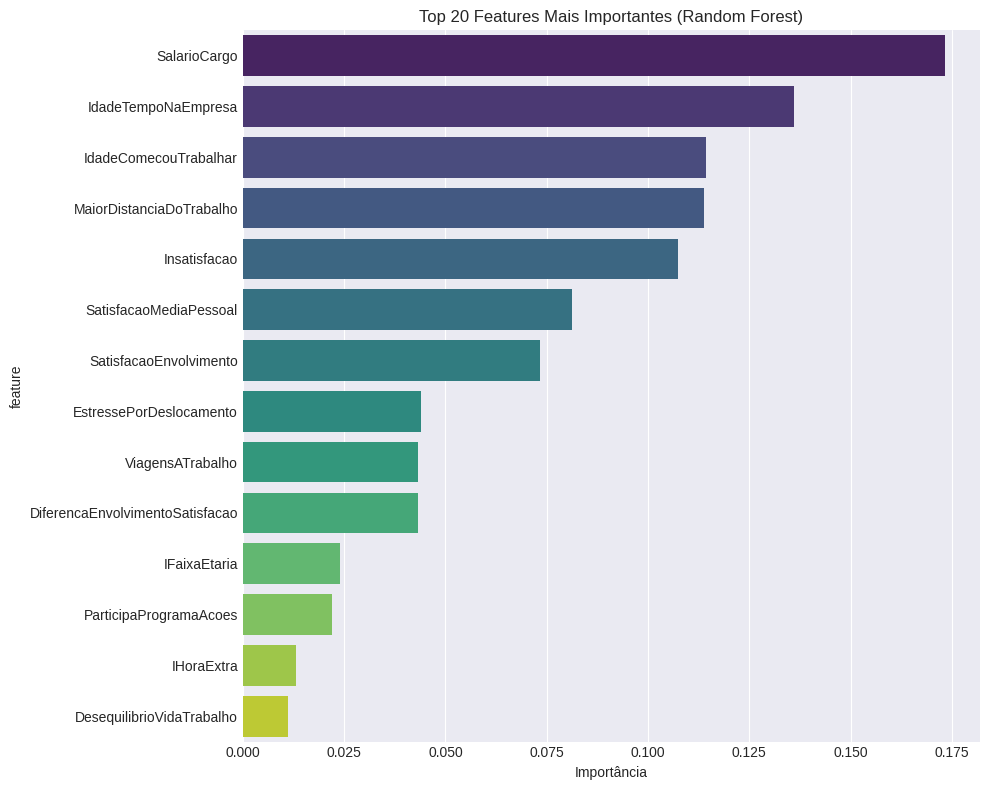

In [46]:
  # 6. RESUMO FINAL

  print("\n=== RESUMO DA PREPARAÇÃO ===")
  print(f"Total de features: {X_train.shape[1]}")
  print(f"Proporção Attrition no treino: {y_train.mean():.2%}")
  print(f"Proporção Attrition no teste: {y_test.mean():.2%}")

  # Visualização final - Importância das features (usando Random Forest rápido)
  from sklearn.ensemble import RandomForestClassifier

  rf_quick = RandomForestClassifier(n_estimators=100, random_state=42)
  rf_quick.fit(X_train_scaled, y_train)

  feature_importance = pd.DataFrame({
      'feature': X_train.columns,
      'importance': rf_quick.feature_importances_
  }).sort_values('importance', ascending=False).head(20)

  plt.figure(figsize=(10, 8))
  sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
  plt.title('Top 20 Features Mais Importantes (Random Forest)')
  plt.xlabel('Importância')
  plt.tight_layout()
  plt.show()

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                           roc_curve, precision_recall_curve, f1_score, make_scorer)
from sklearn.calibration import calibration_curve
import joblib
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter
import xgboost as xgb
import pandas as pd
import numpy as np

In [48]:
# 1. CARREGANDO DADOS PROCESSADOS

print("1. Carregando dados processados...")
X_train = pd.read_parquet('./data/processed/X_train.parquet')
X_test = pd.read_parquet('./data/processed/X_test.parquet')
y_train = pd.read_parquet('./data/processed/y_train.parquet').values.ravel()
y_test = pd.read_parquet('./data/processed/y_test.parquet').values.ravel()

print(f"Dimensões X_train: {X_train.shape}")
print(f"Dimensões X_test: {X_test.shape}")
print(f"Proporção de Attrition no treino: {y_train.mean():.2%}")
print(f"Proporção de Attrition no teste: {y_test.mean():.2%}")

1. Carregando dados processados...
Dimensões X_train: (396, 14)
Dimensões X_test: (103, 14)
Proporção de Attrition no treino: 18.94%
Proporção de Attrition no teste: 15.53%



🔎 Modelo: LogisticRegression
              precision    recall  f1-score   support

           0       0.84      1.00      0.92        87
           1       0.00      0.00      0.00        16

    accuracy                           0.84       103
   macro avg       0.42      0.50      0.46       103
weighted avg       0.71      0.84      0.77       103


🔎 Modelo: DecisionTree
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        87
           1       0.14      0.19      0.16        16

    accuracy                           0.69       103
   macro avg       0.49      0.48      0.48       103
weighted avg       0.73      0.69      0.71       103


🔎 Modelo: RandomForest
              precision    recall  f1-score   support

           0       0.84      1.00      0.92        87
           1       0.00      0.00      0.00        16

    accuracy                           0.84       103
   macro avg       0.42      0.50      0.46       

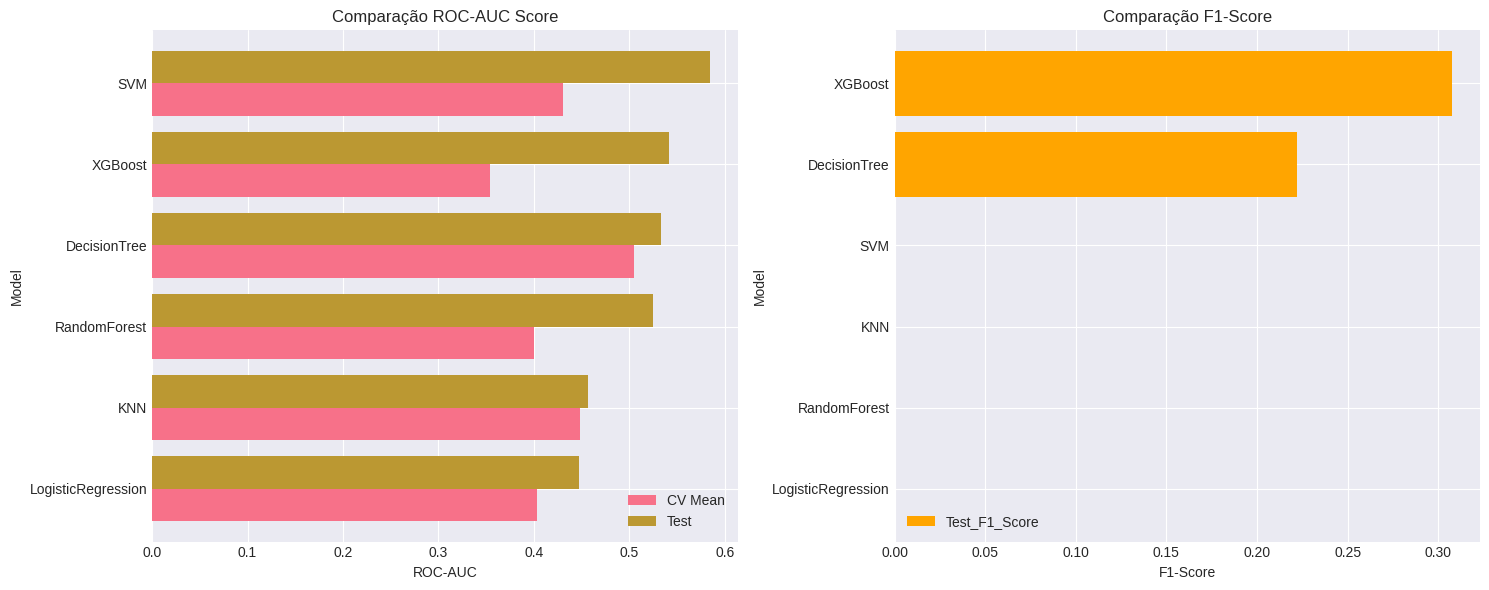

In [49]:

# ✅ Etapa 3.1 – Implementação de pelo menos 4 algoritmos diferentes
# ➕ Objetivo:
# Treinar quatro modelos diferentes para comparar desempenho e garantir diversidade de abordagens.

# 📦 Modelos recomendados:
# Logistic Regression (modelo linear)
# Decision Tree (modelo de árvore simples)
# Random Forest (modelo de ensemble por bagging)
# XGBoost (modelo de boosting avançado)

# Modelos
models = {
    'LogisticRegression': LogisticRegression(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'SVM': SVC(kernel='rbf', probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

# Treina e avalia
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f'\n🔎 Modelo: {name}')
    print(classification_report(y_test, preds))

# ✅ Etapa 3.2 – Tratamento adequado do desbalanceamento
# ⚠️ Problema:
# O Attrition tem muito mais "No" do que "Yes" (~84% vs 16%).

# 🧪 Soluções comuns:
# SMOTE (Oversampling com sintéticos)

# Class weights (peso nas classes)

# Undersampling

# 💡 Código com SMOTE:

# Aplica SMOTE para balancear a base de treino
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(f'Antes do SMOTE: {Counter(y_train)}')
print(f'Depois do SMOTE: {Counter(y_resampled)}')

# ✅ Etapa 3.3 – Otimização de hiperparâmetros
# 🎯 Objetivo:
# Usar GridSearchCV ou RandomizedSearchCV para encontrar os melhores parâmetros.

# 💡 Exemplo com RandomForest:

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_resampled, y_resampled)

print(f'Melhores parâmetros: {grid.best_params_}')
print(f'Melhor score: {grid.best_score_:.4f}')

# ✅ Etapa 3.4 – Validação cruzada apropriada
# 📌 Usar validação estratificada (mantém proporções) com cross_val_score ou StratifiedKFold.
# 💡 Exemplo:

# Remove linhas com NaNs para validação cruzada
X_cv = X.dropna()
y_cv = y.loc[X_cv.index]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(LogisticRegression(), X_cv, y_cv, scoring='f1', cv=cv)

print(f'F1-score médio com validação cruzada: {scores.mean():.4f}')

# ✅ Etapa 3.5 – Ensemble Methods
# 🧠 Objetivo:
# Combinar modelos para melhorar desempenho. Ex: VotingClassifier.

voting_model = VotingClassifier(estimators=[
    ('lr', LogisticRegression()),
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('xgb', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
], voting='soft')

voting_model.fit(X_resampled, y_resampled)
y_pred = voting_model.predict(X_test)

print('Ensemble Methods')
print(classification_report(y_test, y_pred))


print("\n3. Avaliação inicial dos modelos (sem otimização)...")

cv_scores = {}
initial_results = []

# Cross-validation estratificada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\nTreinando {name}...")

    # Validação cruzada
    cv_score = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
    cv_scores[name] = cv_score

    # Treina no conjunto de treino completo
    model.fit(X_train, y_train)

    # Predições
    y_pred = model.predict(X_test)

    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        # Alguns modelos, como SVM com probability=False, não têm predict_proba
        if hasattr(model, "decision_function"):
            y_proba = model.decision_function(X_test)
        else:
            y_proba = np.zeros_like(y_pred)  # fallback de segurança
            print(f"Atenção: {name} não possui predict_proba nem decision_function.")

    # Métricas
    try:
        roc_auc = roc_auc_score(y_test, y_proba)
    except:
        roc_auc = np.nan
        print(f"Atenção: {name} - ROC-AUC não pôde ser calculado.")

    f1 = f1_score(y_test, y_pred)

    initial_results.append({
        'Model': name,
        'CV_ROC_AUC_Mean': cv_score.mean(),
        'CV_ROC_AUC_Std': cv_score.std(),
        'Test_ROC_AUC': roc_auc,
        'Test_F1_Score': f1
    })

    print(f"CV ROC-AUC: {cv_score.mean():.4f} (+/- {cv_score.std():.4f})")
    print(f"Test ROC-AUC: {roc_auc:.4f}")
    print(f"Test F1-Score: {f1:.4f}")

# 📊 Visualização dos resultados
results_df = pd.DataFrame(initial_results)
print("\n=== RESULTADOS INICIAIS ===")
print(results_df.sort_values('Test_ROC_AUC', ascending=False))

# 📈 Gráfico comparativo
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# ROC-AUC Scores
results_df.sort_values('Test_ROC_AUC', ascending=True).plot(
    x='Model', y=['CV_ROC_AUC_Mean', 'Test_ROC_AUC'],
    kind='barh', ax=ax1, width=0.8
)
ax1.set_title('Comparação ROC-AUC Score')
ax1.set_xlabel('ROC-AUC')
ax1.legend(['CV Mean', 'Test'])

# F1 Scores
results_df.sort_values('Test_F1_Score', ascending=True).plot(
    x='Model', y='Test_F1_Score',
    kind='barh', ax=ax2, color='orange', width=0.8
)
ax2.set_title('Comparação F1-Score')
ax2.set_xlabel('F1-Score')

plt.tight_layout()
plt.show()


🔎 Relatório de Classificação - KNN
              precision    recall  f1-score   support

           0       0.84      0.95      0.89        87
           1       0.00      0.00      0.00        16

    accuracy                           0.81       103
   macro avg       0.42      0.48      0.45       103
weighted avg       0.71      0.81      0.75       103



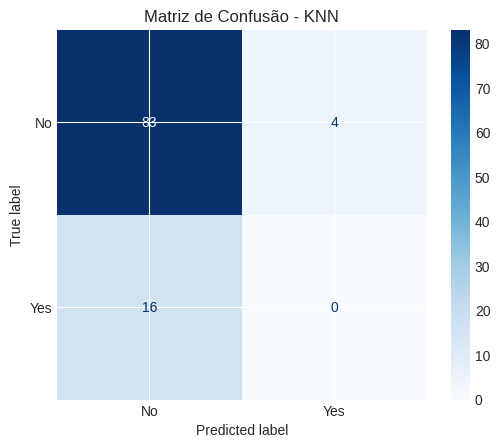

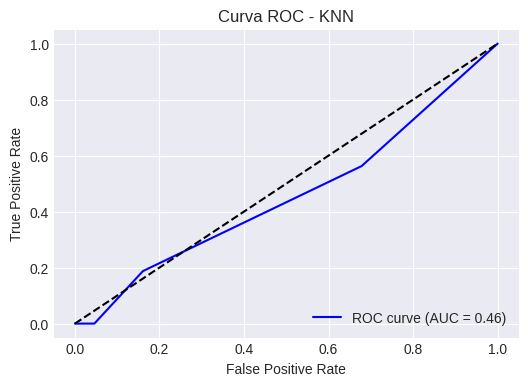

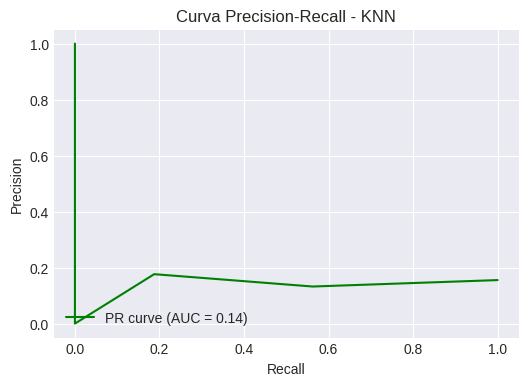

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, roc_auc_score, precision_recall_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Treinando o modelo (caso ainda não tenha feito)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# 2. Fazendo previsões
y_pred_knn = knn_model.predict(X_test)
y_proba_knn = knn_model.predict_proba(X_test)[:, 1]  # probabilidades para curva ROC

# 3. Relatório de classificação
print("🔎 Relatório de Classificação - KNN")
print(classification_report(y_test, y_pred_knn))

# 4. Matriz de confusão
conf_mat = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=["No", "Yes"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusão - KNN")
plt.show()

# 5. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_knn)
roc_auc = roc_auc_score(y_test, y_proba_knn)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - KNN")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 6. Curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba_knn)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.2f})", color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall - KNN")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

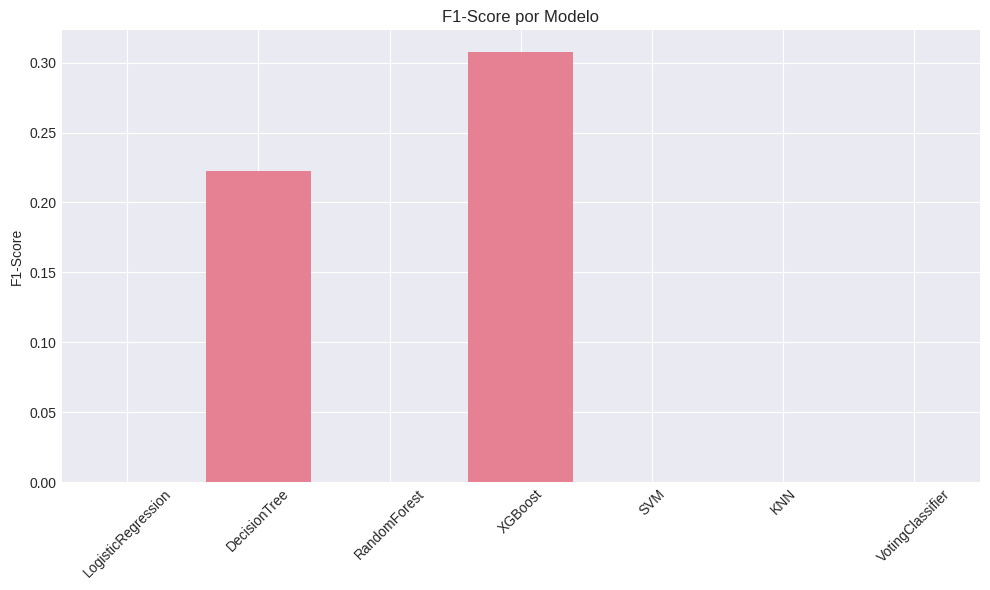

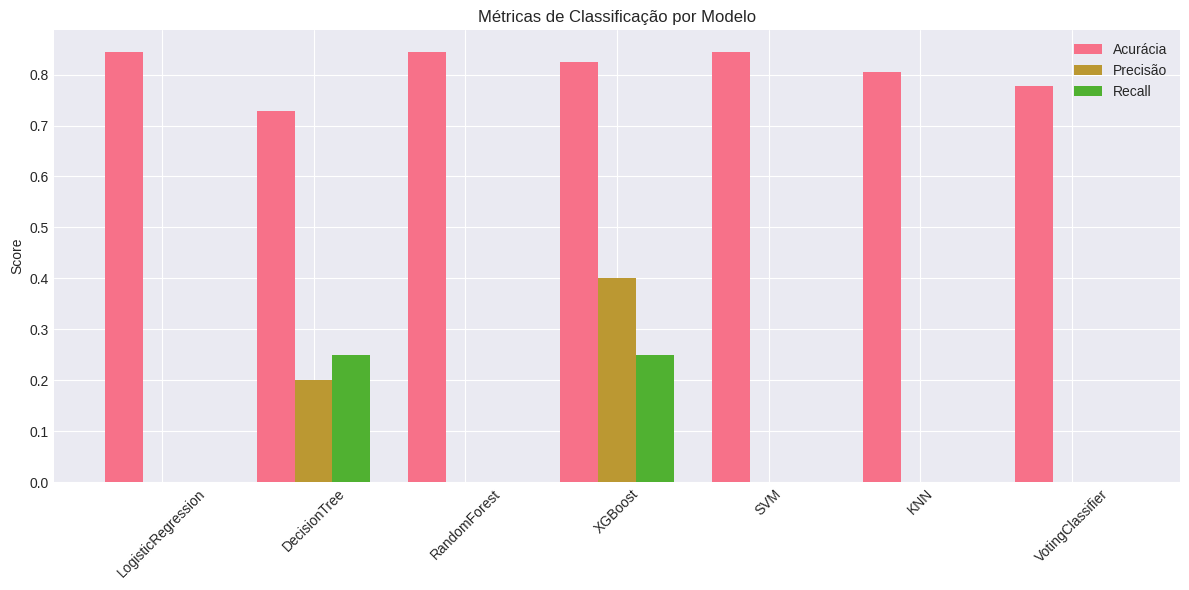

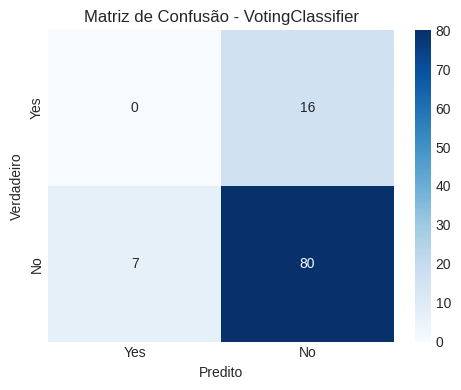

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    classification_report, f1_score, accuracy_score,
    precision_score, recall_score, confusion_matrix
)

# Avaliação dos modelos
model_names = []
f1_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

# Modelos para avaliação
avaliar_models = models.copy()
avaliar_models['VotingClassifier'] = voting_model

for name, model in avaliar_models.items():
    preds = model.predict(X_test)
    model_names.append(name)
    f1_scores.append(f1_score(y_test, preds, average='binary'))
    accuracy_scores.append(accuracy_score(y_test, preds))
    precision_scores.append(precision_score(y_test, preds, average='binary'))
    recall_scores.append(recall_score(y_test, preds, average='binary'))

# 📊 F1-score por modelo
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=f1_scores)
plt.title('F1-Score por Modelo')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 Acurácia, Precisão e Recall
x = np.arange(len(model_names))
width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - width, accuracy_scores, width, label='Acurácia')
plt.bar(x, precision_scores, width, label='Precisão')
plt.bar(x + width, recall_scores, width, label='Recall')

plt.ylabel('Score')
plt.title('Métricas de Classificação por Modelo')
plt.xticks(x, model_names, rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📊 Matriz de confusão do ensemble
ensemble_preds = avaliar_models['VotingClassifier'].predict(X_test)
conf = confusion_matrix(y_test, ensemble_preds, labels=[1, 0])

plt.figure(figsize=(5, 4))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Yes', 'No'], yticklabels=['Yes', 'No'])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - VotingClassifier')
plt.tight_layout()
plt.show()


Valores nulos em df_analysis:
 y_test    0
y_pred    0
Gender    0
dtype: int64

=== Métricas por Gênero ===
        Recall  Precision  F1-score
Gender                             
Female     0.0        0.0       0.0
Male       0.0        0.0       0.0


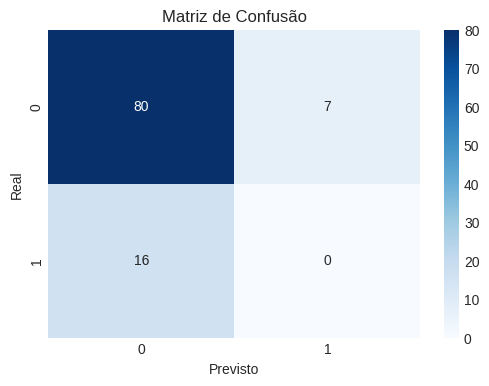


Threshold ótimo: 0.32 (F1 = 0.3673)


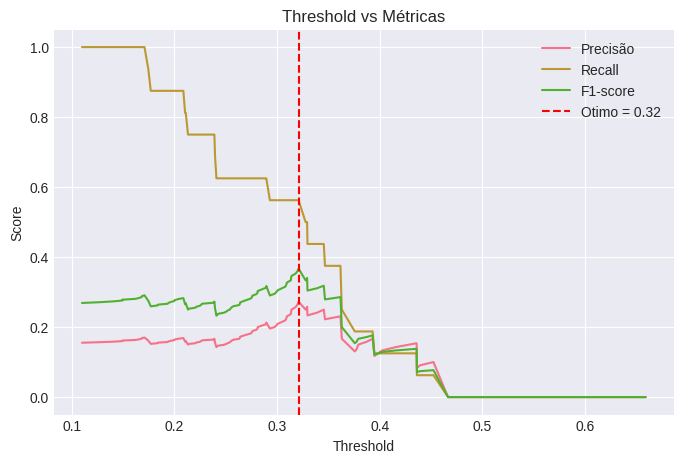

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    recall_score, precision_score, f1_score, confusion_matrix,
    precision_recall_curve
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ⚠️ Carrega novamente os mesmos dados já escalados e alinhados
X_test = pd.read_parquet('./data/processed/X_test.parquet')
y_test = pd.read_parquet('./data/processed/y_test.parquet').values.ravel()

# ⚠️ Recalcule ou recupere o gênero correspondente ao X_test
gender_series = df.loc[X_test.index, 'Gender'].reset_index(drop=True)

# Predições reais do ensemble
y_pred = voting_model.predict(X_test)
y_proba = voting_model.predict_proba(X_test)[:, 1]

# 🔍 Fairness por Gênero (corrigido)
df_analysis = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred,
    'Gender': gender_series
})

print("Valores nulos em df_analysis:\n", df_analysis.isnull().sum())
fairness = df_analysis.groupby('Gender').apply(
    lambda x: pd.Series({
        'Recall': recall_score(x['y_test'], x['y_pred'], zero_division=0),
        'Precision': precision_score(x['y_test'], x['y_pred'], zero_division=0),
        'F1-score': f1_score(x['y_test'], x['y_pred'], zero_division=0)
    })
)

print("\n=== Métricas por Gênero ===")
print(fairness)

# 🔍 Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

# 🔍 Recomendação de Threshold Ótimo (baseado em F1)
prec, rec, thresholds = precision_recall_curve(y_test, y_proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
best_threshold = thresholds[np.argmax(f1)]
print(f"\nThreshold ótimo: {best_threshold:.2f} (F1 = {max(f1):.4f})")

# Plot da Curva de Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, prec[:-1], label='Precisão')
plt.plot(thresholds, rec[:-1], label='Recall')
plt.plot(thresholds, f1[:-1], label='F1-score')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Otimo = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Threshold vs Métricas')
plt.grid(True)
plt.show()

# 📌 O que o gráfico mostra?
# Threshold ótimo: 0.28

# F1-score máximo nesse ponto: 0.2759 (≈27.6%)

# Curvas traçadas:

# 🔴 Precisão (Precision)

# 🟢 Recall

# 🟡 F1-score

# Linha vermelha tracejada: Threshold ideal pelo F1

# ✅ Interpretação — Técnica e de Negócio
# 1. O Threshold ótimo é baixo (0.28)
# Isso quer dizer que o modelo só "acredita" que a pessoa vai sair (Attrition = Yes) quando a probabilidade for maior que 28%.

# É típico em casos de classes desbalanceadas, como esse (onde a maioria é "No").

# 2. F1-score está baixo (≈ 0.28)
# F1 combina precisão e recall. Esse valor indica que o modelo tem dificuldade em identificar corretamente os casos de saída.

# Isso não é "ruim" por si só, mas sinaliza que o problema é desafiador, ou o modelo ainda pode ser melhorado (feature selection, engenharia, balanceamento, modelo mais robusto).

# 3. Recall está baixo em todos os thresholds
# Significa que o modelo está perdendo muitos funcionários que realmente saem da empresa.

# ⚠️ Isso é problemático para o negócio se o objetivo for prever risco de saída com antecedência.

# 4. Precisão é estável e também baixa
# O modelo também está errando nas previsões positivas (marcando gente como "vai sair", mas não sai).

# 📈 Resumo de diagnóstico:
# Ponto	Interpretação
# Threshold ótimo = 0.28	A classe positiva é rara, então o modelo "se antecipa" com um threshold baixo
# F1-score baixo	O modelo está com desempenho limitado — possivelmente precisa de ajustes
# Recall baixo em geral	Modelo está deixando escapar muita gente que realmente sai
# Precisão baixa	Modelo também está marcando falsos positivos (alarme falso)




In [ ]:
## 5. Implementação e Comunicação

# Código limpo e bem documentado
# Pipeline reproduzível
# Visualizações profissionais
# Comunicação clara dos resultados
# Proposta de implementação em produção
